# Lecture 15 - Convolutional Neural Networks with Keras-TensorFlow

[![View notebook on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/avakanski/Fall-2025-Applied-Data-Science-with-Python/blob/main/docs/Lectures/Theme_3-Model_Engineering/Lecture_15-ConvNets/Lecture_15-ConvNets.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/avakanski/Fall-2025-Applied-Data-Science-with-Python/blob/main/docs/Lectures/Theme_3-Model_Engineering/Lecture_15-ConvNets/Lecture_15-ConvNets.ipynb)

<a id='top'></a>

- [15.1 Introduction to Convolutional Neural Networks](#15.1-introduction-to-convolutional-neural-networks)
- [15.2 Loading the Dataset](#15.2-loading-the-dataset)
- [15.3 Creating, Training, and Evaluating a CNN Model](#15.3-creating,-training,-and-evaluating-a-cnn-model)
- [15.4 Introduce a Validation Dataset](#15.4-introduce-a-validation-dataset)
- [15.5 Dropout Layers](#15.5-dropout-layers)
- [15.6 Batch Normalization](#15.6-batch-normalization)
- [15.7 Data Augmentation](#15.7-data-augmentation)
- [15.8 Transfer Learning](#15.8-transfer-learning)
- [References](#references)

## 15.1 Introduction to Convolutional Neural Networks <a name='15.1-introduction-to-convolutional-neural-networks'></a>

**Convolutional Neural Networks (CNNs)**, also known as **ConvNets** have accelerated various computer vision tasks, such as image recognition and classification, image segmentation, and object detection. CNNs have been used in related applications, including autonomous vehicles, medical image diagnosis, intelligent robots, and others.

A typical architecture of CNN is shown below and consists of 3 main types of layers: convolutional layers, pooling layers, and fully-connected (dense) layers. CNNs typically have multiple blocks of convolutional and pooling layers, followed by fully-connected layers. The optimal number of layers is task-dependent, and it is a hyperparameter that needs to be tuned by the user during the training and model selection.

<img src="images/cnn_layers.png" width="650">

*Figure: Architecture of a CNN.*

Each layer in CNNs transforms the input images into a higher-level representation. The initial layers in CNNs learn low-level features (such as edges and lines), the middle layers learn mid-level features (e.g., textures and parts), and the last layers learn high-level features (such as objects). The fully-connected layers use the high-level features to classify the input image.

<img src="images/cnn_features.png" width="750">

*Figure: Extracted features in a CNN.*

### Convolutional Layers

The process of convolution is to pass a convolutional filter to each pixel in an image, multiply the corresponding pixels, and calculate the sum. This process is repeated until the filter is slid over all image pixels.

<img src="images/convolution.gif" width="750">

*Figure: Convolution process.*

Modern deep learning libraries, such as TensorFlow and PyTorch, allow to create convolutional layers in one line of code, as follows.


    tensorflow.keras.layers.Conv2D(.....)


Beside 2D convolutional filters that are used for processing images, 3D convolutional layers are used for analyzing videos, and 1D convolutional layers are used for analyzing time-series data.

The output of a convolutional layer is high-dimensional feature maps, and its dimension depends on the number of convolutional filters used in the layer. For example, if the layer has 32 filters, then we will have 32 feature maps at the output.

### Pooling layers

Pooling layers are used to reduce the size of the feature maps output by convolutional layers, which reduces the number of network parameters and the computational cost for training the model. Pooling layers are also helpful for selecting more imporant information from the feature maps in the previous layer, they reduce the sensitivity of the model to the exact location of objects in inputs images, and they reduce the impact of noise in input data.

There are different pooling options, although the most common is the Maxpooling layer, which reduces the image sizes by keeping the pixels with the maximum intensity.

Implementing a pooling layer in most frameworks is very simple. The following figure depicts Maxpooling with a pool_size=2, which means that the output is the maximum value for each square of 2x2 pixels.


    tensorflow.keras.layers.MaxPooling2D(...)


<img src="images/max-pooling.jpg" width="500">

*Figure: Pooling layer with a pool_size=2.*

The portion of the network that consists of convolutional and pooling layers is often called an **encoder**, since it is used for encoding the information in input data into a representation that is more useful for the task at hand. Similarly, the portion of the network that consists of fully-connected layers is referred to as *classifier* (*head*, *top*) of the network.


### Fully-connected Layers (Densely-connected Layers)

The last layers in ConvNets are fully-connected layers, that match the produced feature maps from the previous layers to the labels of the original image.


```
tensorflow.keras.layers.Dense(....)
```

## 15.2 Loading the Dataset <a name='15.2-loading-the-dataset'></a>

In this notebook, we are going to use one of the most well-known datasets for image classification called `CIFAR-10`.

CIFAR-10 consists of 60,000 color images in 10 categories. The 10 classes are: `airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck`.

Each class contains 6,000 images. In the dataset, 50,000 images are allocated for training, and 10,000 for testing. The top accuracy on the test dataset is about 90%.

You can learn more about the dataset [here](https://www.cs.toronto.edu/%7Ekriz/cifar.html).

Note that there is a larger version with 100 classes called CIFAR-100.

CIFAR-10 is available in Keras built-in datasets, so we can simply load the data by using the helper function `keras.datasets.cifar10.load_data()`.

In [ ]:
# import required libraries
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Print the version of tf
print("TensorFlow version:{}".format(tf.__version__))

TensorFlow version:2.19.0


In [ ]:
# Load the train and test images and labels
(train_data, train_label), (test_data, test_label) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


As usual, we can inspect the shapes of the training and testing datasets.

Note that each image is a 32x32x3 tensor, having a size of 32x32 pixels and 3 channels corresponding to the RGB (red-green-blue) channels.

In [ ]:
print('Training images', train_data.shape)
print('Training labels', train_label.shape)
print('Testing images', test_data.shape)
print('Testing labels', test_label.shape)

Training images (50000, 32, 32, 3)
Training labels (50000, 1)
Testing images (10000, 32, 32, 3)
Testing labels (10000, 1)


### Data Preprocessing

The values for the pixel intensities in the images are in the range between 0 and 255. The type is `uint8` which stands for unsigned integer with 8 bits, that is, the possible values are between $2^0=1$ and $2^8=256$. This means that each pixel has an intensity value in that range, where 0 is a black pixel, 255 is a white pixel, and all other colors are in between.

In [ ]:
# Display the range of images
print('Max pixel value', np.max(train_data))
print('Min pixel value', np.min(train_data))
print('Average pixel value', np.mean(train_data))
print('Data type', train_data[0].dtype)

Max pixel value 255
Min pixel value 0
Average pixel value 120.70756512369792
Data type uint8


When processing image data with neural networks, the pixel values are commonly normalized to the [0, 1] range. This allows the networks to train faster and it usually leads to better results. Let's normalize the images by dividing them with the maximum intensity of 255, and check again if the scaled data look correct. Note that the data type after the normalization is `float64`.

In [ ]:
# Normalize the images
train_data = train_data / 255
test_data = test_data / 255

In [ ]:
# Display the range of images (to make sure they are in the [0, 1] range)
print('Max pixel value', np.max(train_data))
print('Min pixel value', np.min(train_data))
print('Average pixel value', np.mean(train_data))
print('Data type', train_data[0].dtype)

Max pixel value 1.0
Min pixel value 0.0
Average pixel value 0.4733630004850874
Data type float64


   The labels for the 10 classes in CIFAR-10 are shown below.
   
| Label | Description |
| ----- | ----------- |
| 0     | airplane    |
| 1     | automobile  |
| 2     | bird        |
| 3     | cat         |
| 4     | deer        |
| 5     | dog         |
| 6     | frog        |
| 7     | horse       |
| 8     | ship        |
| 9     | truck       |


Let's inspect the first 10 values in the labels. We can see that each label corresponds to one of the 10 categories.

Also, in the next cell we plotted the first 100 labels, and we can notice that they have values between 0 and 9, so everything looks good.

In [ ]:
print(train_label[:10])

[[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]


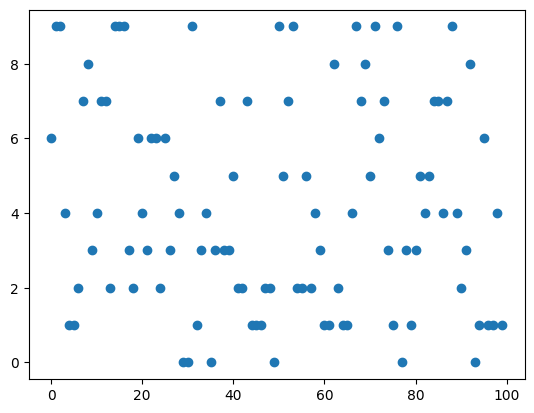

In [ ]:
plt.plot(train_label[:100], 'o')
plt.show()

Let's visualize some images to see what they look like. We can notice that the resolution is quite low, since they are 32x32 pixels.

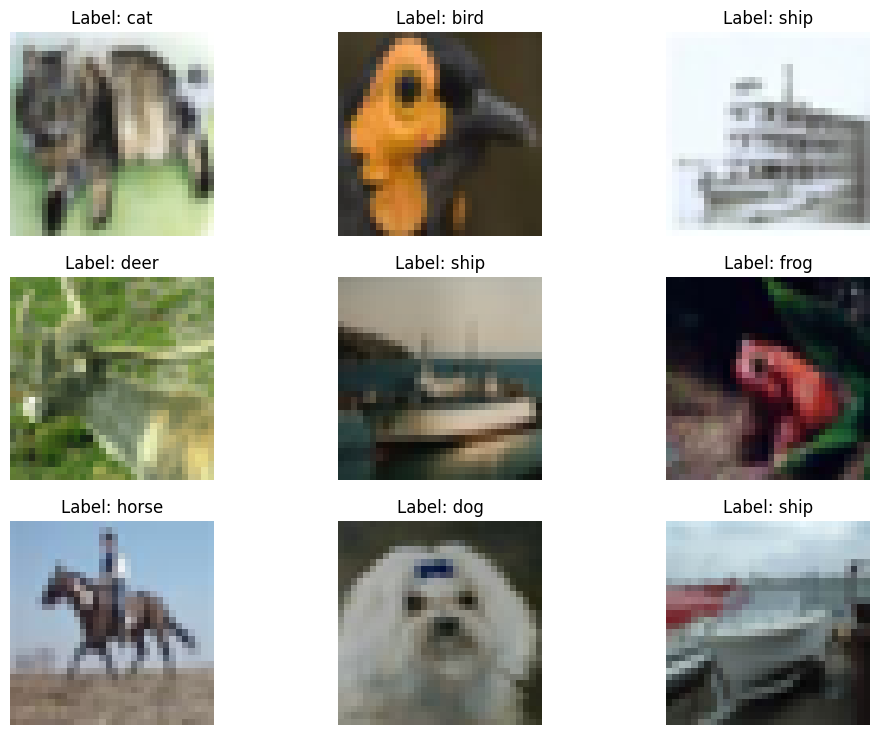

In [ ]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot a few images to check if the labels are correct
plt.figure(figsize=(12, 9))
for n in range(9):
    i = np.random.randint(0, len(train_data), 1)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(train_data[i[0]])
    plt.title('Label: ' + str(label_names[train_label[i[0]][0]]))
    plt.axis('off')

## 15.3 Creating, Training, and Evaluating a CNN Model <a name='15.3-creating,-training,-and-evaluating-a-cnn-model'></a>

### Create the CNN

Next, we are going to define the network architecture with the TensorFlow-Keras library. Recall from the previous lecture that the main data structures in Keras are **layers** and **models**.

In the first cell below we imported the layers, and afterward we defined the layers.

We need to first introduce an **Input** layer to provide the size of the data, and in this case, the shape of the input data is set to (32,32,3). This is because the images are arrays with shape 32x32x3.

Next, we will include a convolutional layer **Conv2D**. The arguments of Conv2D layer in Keras are:

- `filters`: define the number of filters in the layer.
- `kernel_size`: the height and width of each filter, defined as an integer such as `kernel_size=3`, or a tuple such as `kernel_size=(3,3)`.
- `padding`: it is not a very important argument, when it is equal to `'same'` it means that the output images are the same size as input images; otherwise, the output images can be slightly smaller.

Next, we will include a pooling layer **MaxPooling2D**. We can specify the pooling size with the `pool_size` argument, such as `pool_size=3`. Otherwise, the default pool size is 2.

ConvNets typically consist of several blocks of convolutional and pooling layers.

And **Fully Connected Layers** are used for matching the compressed feature maps to their labels.

And there is one more layer that is used called **Flatten**. This layer is needed because the outputs of the convolutional and maxpooling layers are 3-dimensional tensors, but the dense layers require one-dimensional data (vectors). The Flatten layer just concatenates (flattens) all dimensions of a tensor into an 1D array.

For example, the following layer that we defined below,

```
conv1b = Conv2D(filters=32, kernel_size=3, padding='same')(conv1a)
```

is a convolutional layer, which takes as input the previous layer named `conv1a`. The layer `conv1b` has 32 convolutional filters of size 3, and padding is applied to preserve the size of the images.

In [ ]:
# import the layers and the model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.models import Model

In [ ]:
# Define the layers in the model
inputs = Input(shape=(32, 32, 3))
conv1a = Conv2D(filters=32, kernel_size=3, padding='same')(inputs)
conv1b = Conv2D(filters=32, kernel_size=3, padding='same')(conv1a)
pool1 = MaxPooling2D()(conv1b)
conv2a = Conv2D(filters=64, kernel_size=3, padding='same')(pool1)
conv2b = Conv2D(filters=64, kernel_size=3, padding='same')(conv2a)
pool2 = MaxPooling2D()(conv2b)
conv3a = Conv2D(filters=128, kernel_size=3, padding='same')(pool2)
conv3b = Conv2D(filters=128, kernel_size=3, padding='same')(conv3a)
pool3 = MaxPooling2D()(conv3b)
flat = Flatten()(pool3)
dense1 = Dense(128, activation='relu')(flat)
dense2 = Dense(64, activation='relu')(dense1)
outputs = Dense(10, activation='softmax')(dense2)

In [ ]:
# Define the model with inputs and outputs
cifar_cnn = Model(inputs, outputs)

Also note that in multi-class classification problems, the last Dense layer has
**softmax** activation function. Softmax activation outputs a multiclass probability distribution, that is, it computes the probability that an image belongs to one of the 10 classes.

After we define the layers, we create the model as an instance of the `Model` class, for which the arguments are the input and output layers.

We can inspect the architecture of the CNN with `cifar_cnn.summary()`.

In [ ]:
# Model summary
cifar_cnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 558,186 (2.13 MB)

 Trainable params: 558,186 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

### Compile the CNN

Next, we need to compile the model, and provide the loss function, optimizer, and metric.

From the previous lecture, we know that the following three crossentropy losses are commonly used in Keras:

- `binary_crosssentropy` used for binary classification (i.e., there are only 2 classes).
- `categorical_crossentropy` used for multiclass classification (3 and more classes) and the target labels are encoded in one-hot matrix format.
- `sparse_categorical_crossentropy` used for multiclass classification (3 and more classes) and the target labels are encoded in ordinal format.

Since the target labels are encoded in ordinal format, we will use sparse categorical crossentropy.

Let's use the Adam optimizer, and accuracy metric.

In [ ]:
cifar_cnn.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

### Train the CNN

Training CNNs is similar to training Fully-connected NNs. We use the `fit` function and list the train data and labels, number of epochs, and batch size. Here we used a batch size of 128 images, hence, since the training dataset has 50,000 images, the updates of the model parameters will be repeated 50,000/128 = 391 times (notice this number under the Epoch in the cell output below). Since we selected 10 epochs, this means there will be 3,910 training steps in total.


In [ ]:
cifar_cnn.fit(train_data, train_label, epochs=10, batch_size=128)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.3859 - loss: 1.6923
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6537 - loss: 0.9874
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7307 - loss: 0.7726
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7786 - loss: 0.6254
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8208 - loss: 0.5158
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8491 - loss: 0.4243
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8780 - loss: 0.3479
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8945 - loss: 0.2940
Epoch 9/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9120 - loss: 0.2487
Epoch 10/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9224 - loss: 0.2181


### Evaluate on Test Data



We can first use the `predict` function to output the class for each image in the test dataset, and afterward use `accuracy_score` to calculate the accuracy.

In [ ]:
from sklearn.metrics import accuracy_score

preds = cifar_cnn.predict(test_data)

accuracy = accuracy_score(test_label, np.argmax(preds, axis=1))
print('The test accuracy is {0:5.2f} %'.format(accuracy*100))

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
The test accuracy is 73.18 %


We can check that the shape of the predicted outputs is `(10000,10)`, since there are 10,000 test images and 10 classes.

Let's also display the predictions for the first 5 test images in the following cell. The model outputs probabilities for each of the 10 classes. The probabilities sum to 1. For instance, for the first test image, the model assigned the highest probability of 0.801 to the class with index 5.

In [ ]:
# check the shape of the predictions
preds.shape

(10000, 10)

In [ ]:
# display the predictions for the first 5 test images
print('Predictions for first 5 test images:\n', np.around(preds[:5],3))

Predictions for first 5 test images:
 [[0.    0.    0.    0.694 0.    0.304 0.003 0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    1.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    1.    0.   ]
 [0.999 0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.88  0.005 0.    0.115 0.    0.    0.   ]]


Next, let's output the indices with the highest probability for each image with `np.argmax`, and compare them to the ground-truth labels.

In [ ]:
# print the index with highest probability for the first 5 test images
np.argmax(preds[:5], axis=1)

array([3, 8, 8, 0, 3])

In [ ]:
# print the ground-truth label for the first 5 test images
test_label[:5]

array([[3],
       [8],
       [8],
       [0],
       [6]], dtype=uint8)

And, a simpler way to calculate only the accuracy is with `evaluate`.

In [ ]:
# Evaluate on test dataset
evals_test = cifar_cnn.evaluate(test_data, test_label)
print("Classification Accuracy: ", evals_test[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7316 - loss: 1.1418
Classification Accuracy:  0.7318000197410583


The important thing to notice is that the accuracy on the training dataset reached above 90%, while the accuracy on the test dataset is about 73%. This means that the model overfits the training data. That is, the model begins to memorize the training data, and it learns to predict on the training dataset very well, but the generalization ability on unseen images is quite low. In the next sections we will learn how to deal with that.  

### Plot the Predictions

But first, let's plot a few images and the predicted class labels by the model.

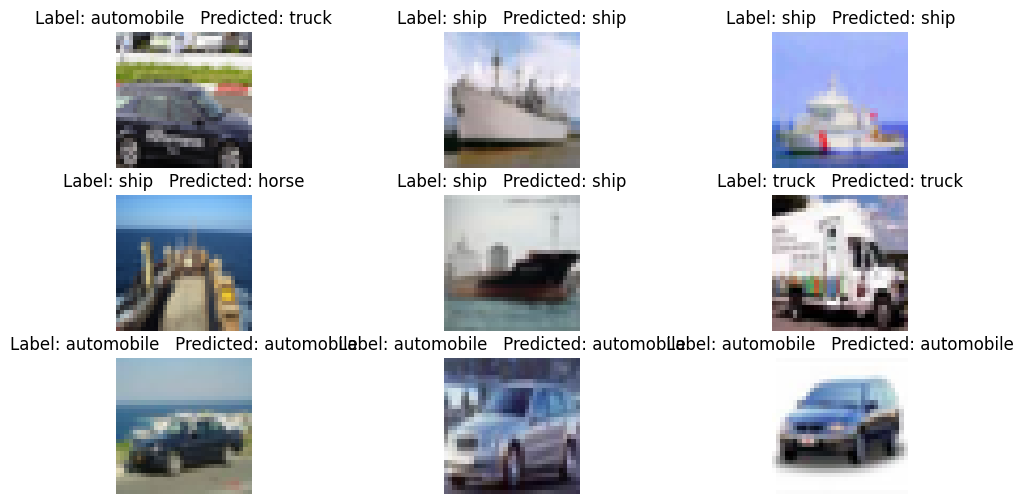

In [ ]:
# Plot a few images to check them
plt.figure(figsize=(12, 6))
for n in range(9):
    i = np.random.randint(0, len(test_data), 1)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(test_data[i[0]])
    plt.title('Label: ' + str(label_names[test_label[i[0]][0]]) + '   Predicted: ' + str(label_names[np.argmax(preds[i[0]])]))
    plt.axis('off')

## 15.4 Introduce a Validation Dataset <a name='15.4-introduce-a-validation-dataset'></a>

To be able to observe if the model overfits, one more dataset is introduced, referred to as a **validation dataset**. The original training dataset is typically randomly split, and approximately 70-80% is used as a training dataset, and 20-30% is used as a validation dataset.

This way, at the end of every epoch, we will calculate the accuracy of the model on the validation dataset. As the model is trained, if the training accuracy increases, but the validation accuracy decreases, it means that the model begins to overfit.

In Keras, the `fit` function has a `validation_split` argument, which allows us to use a percent of the training data for validation. In the next cell, we will use 20%, meaning that out of the 50,000 training images, the model will use 40,000 for training, and 10,000 for validation. An alternative way to introduce validation dataset is to first manually split the training dataset into two subsets of data, and in the `fit` function to pass the validation features and labels as a tuple named `validation_data`. However, the first option with using a `validation_split` argument is much simpler, and therefore preferred.

Note also that in the cell below we will just continue training the same model. I.e., the accuracy value in the first epoch below is a continuation of the accuracy in the last epoch of the previosly trained model.

Now we can notice the overfitting, because the training accuracy continues to increase, but the validation accuracy decreases.

In [ ]:
cifar_cnn.fit(train_data, train_label,
              epochs=10, batch_size=128,
              validation_split=0.2)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.9375 - loss: 0.1786 - val_accuracy: 0.9064 - val_loss: 0.2612
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9444 - loss: 0.1644 - val_accuracy: 0.8966 - val_loss: 0.3236
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9495 - loss: 0.1504 - val_accuracy: 0.8679 - val_loss: 0.4524
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9466 - loss: 0.1512 - val_accuracy: 0.8739 - val_loss: 0.4109
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9540 - loss: 0.1319 - val_accuracy: 0.8589 - val_loss: 0.4641
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9553 - loss: 0.1344 - val_accuracy: 0.8666 - val_loss: 0.4602
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9588 - loss: 0.1195 - val_accuracy: 0.8561 - val_loss: 0.5280
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9633 - loss: 0.1061 - val_accu

In [ ]:
# Evaluate on test dataset
evals_test = cifar_cnn.evaluate(test_data, test_label)
print("Classification Accuracy: ", evals_test[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7269 - loss: 1.7199
Classification Accuracy:  0.7267000079154968


### Training the Model from Scratch

Let's also check the outputs when the same model is trained from scratch, or in other words, the model wieghts are re-initilialized to random values. To do that, we need to recreate the model, compile it again, and then fit it to the data.

In [ ]:
# Define the layers in the model
inputs = Input(shape=(32, 32, 3))
conv1a = Conv2D(filters=32, kernel_size=3, padding='same')(inputs)
conv1b = Conv2D(filters=32, kernel_size=3, padding='same')(conv1a)
pool1 = MaxPooling2D()(conv1b)
conv2a = Conv2D(filters=64, kernel_size=3, padding='same')(pool1)
conv2b = Conv2D(filters=64, kernel_size=3, padding='same')(conv2a)
pool2 = MaxPooling2D()(conv2b)
conv3a = Conv2D(filters=128, kernel_size=3, padding='same')(pool2)
conv3b = Conv2D(filters=128, kernel_size=3, padding='same')(conv3a)
pool3 = MaxPooling2D()(conv3b)
flat = Flatten()(pool3)
dense1 = Dense(128, activation='relu')(flat)
dense2 = Dense(64, activation='relu')(dense1)
outputs = Dense(10, activation='softmax')(dense2)

# Define the model with inputs and outputs
cifar_cnn = Model(inputs, outputs)

cifar_cnn.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

history = cifar_cnn.fit(train_data, train_label,
              epochs=20, batch_size=128,
              validation_split=0.2)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.3301 - loss: 1.8207 - val_accuracy: 0.5762 - val_loss: 1.1786
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6239 - loss: 1.0593 - val_accuracy: 0.6571 - val_loss: 0.9864
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7195 - loss: 0.8018 - val_accuracy: 0.7031 - val_loss: 0.8547
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7742 - loss: 0.6469 - val_accuracy: 0.7269 - val_loss: 0.8096
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8124 - loss: 0.5348 - val_accuracy: 0.7236 - val_loss: 0.8589
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8485 - loss: 0.4315 - val_accuracy: 0.7228 - val_loss: 0.8785
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8705 - loss: 0.3662 - val_accuracy: 0.7334 - val_loss: 0.9049
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8942 - loss: 0.2983 - val_acc

The next cell displays the **learning curves** for the model that show the accuracy and loss of the model. The blue lines indicate the model performance on the training dataset and the red lines indicate the performance on the validation dataset.

The overfitting is noticeable, as the training loss continues decreasing while the validation loss begins to increase after the first 5 epochs. Also, while the training accuracy increases as the training progresses, the validation accuracy is stalled at about 72%.

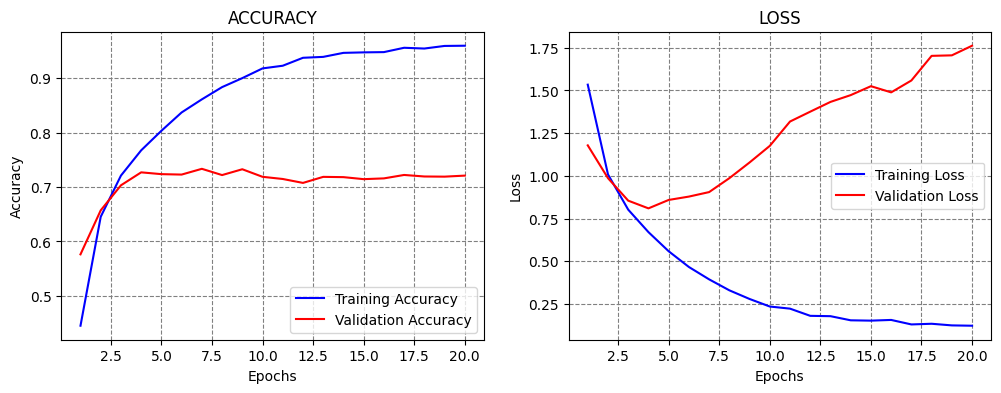

In [ ]:
# plot the accuracy and loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochsn = np.arange(1, len(train_loss)+1,1)
plt.figure(figsize=(12, 4))

plt.subplot(1,2,1)
plt.plot(epochsn, acc, 'b', label='Training Accuracy')
plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
plt.grid(color='gray', linestyle='--')
plt.legend()
plt.title('ACCURACY')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochsn,train_loss, 'b', label='Training Loss')
plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
plt.grid(color='gray', linestyle='--')
plt.legend()
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## 15.5 Dropout Layers <a name='15.5-dropout-layers'></a>

One way to deal with overfitting in neural networks is to introduce **Dropout** layers. The idea of dropout is very simple: during the training, at each step of processing a batch of images, a portion of the neurons in a layer are randomly disabled. This introduces randomness in the network, and it helps to improve model performance and reduce overfitting.

Dropout can be considered to be similar to the ensemble methods, where during each iteration, a slightly different model is trained, which uses only a portion of all neurons.

In the next cell, we add several dropout layers, where for instance, dropout of 0.2 means that 20% of the neurons in that layer are randomly dropped.

In [ ]:
from tensorflow.keras.layers import Dropout

# Define the layers
inputs = Input(shape=(32, 32, 3))
conv1a = Conv2D(filters=32, kernel_size=3, padding='same')(inputs)
conv1b = Conv2D(filters=32, kernel_size=3, padding='same')(conv1a)
pool1 = MaxPooling2D()(conv1b)
dropout1 = Dropout(0.2)(pool1)
conv2a = Conv2D(filters=64, kernel_size=3, padding='same')(dropout1)
conv2b = Conv2D(filters=64, kernel_size=3, padding='same')(conv2a)
pool2 = MaxPooling2D()(conv2b)
dropout2 = Dropout(0.2)(pool2)
conv3a = Conv2D(filters=256, kernel_size=3, padding='same')(dropout2)
conv3b = Conv2D(filters=256, kernel_size=3, padding='same')(conv3a)
pool3 = MaxPooling2D()(conv3b)
flat = Flatten()(pool3)
dense1 = Dense(128, activation='relu')(flat)
dropout3 = Dropout(0.2)(dense1)
dense2 = Dense(64, activation='relu')(dropout3)
dropout4 = Dropout(0.2)(dense2)
outputs = Dense(10, activation='softmax')(dropout4)

In [ ]:
# Define the model with inputs and outputs
cifar_cnn_2 = Model(inputs, outputs)

In [ ]:
# compile model
cifar_cnn_2.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# fit model
history = cifar_cnn_2.fit(train_data, train_label,
                epochs=40, batch_size=128,
                validation_split=0.2, verbose=0)

In [ ]:
# Evaluate on test dataset
evals_test = cifar_cnn_2.evaluate(test_data, test_label)
print("Classification Accuracy: ", evals_test[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7634 - loss: 0.9489
Classification Accuracy:  0.757099986076355


The performance of the model with dropout layers increased slightly to above 75%.

Let's create a figure with the learning curves to show the accuracy and loss of the model. We can notice that overfitting begins around epoch 15, when the training accuracy increases, but the validation accuracy stays about the same. Similarly, the training loss decreases, but the validation loss increases after epoch 15. The plots of the accuracy and loss are fairly correlated, however as we can see the accuracy can stay constant when the loss is changing.

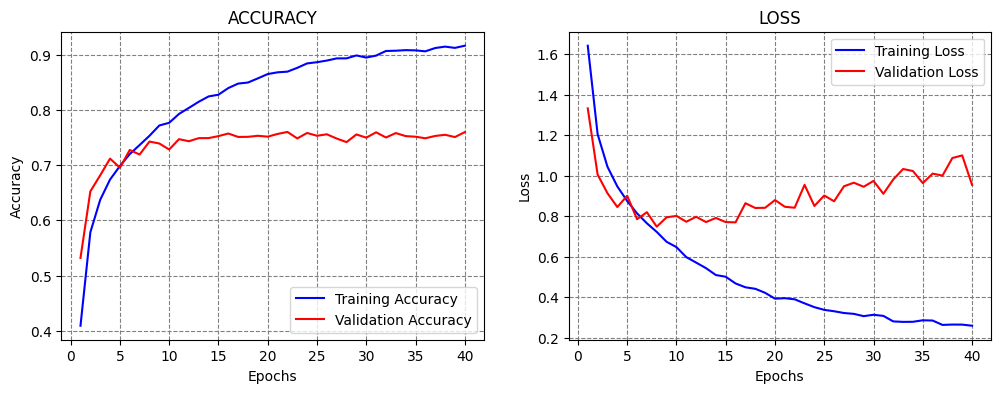

In [ ]:
# plot the accuracy and loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochsn = np.arange(1, len(train_loss)+1,1)
plt.figure(figsize=(12, 4))

plt.subplot(1,2,1)
plt.plot(epochsn, acc, 'b', label='Training Accuracy')
plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
plt.grid(color='gray', linestyle='--')
plt.legend()
plt.title('ACCURACY')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochsn,train_loss, 'b', label='Training Loss')
plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
plt.grid(color='gray', linestyle='--')
plt.legend()
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## 15.6 Batch Normalization <a name='15.6-batch-normalization'></a>

Another type of layers that are used to reduce overfitting are **Batch Normalization** layers.

Similarly to scaling the input features to range [0,1] or to a Gaussian distribution with 0 mean and 1 standard deviation, Batch Normalization layers scale a batch of data to have 0 mean and 1 standard deviation. This reduces the instability in training the network due to differences among batches of data, and also reduces the overfitting.

In [ ]:
from tensorflow.keras.layers import BatchNormalization

# Define the layers
inputs = Input(shape=(32, 32, 3))
conv1a = Conv2D(filters=32, kernel_size=3, padding='same')(inputs)
conv1b = Conv2D(filters=32, kernel_size=3, padding='same')(conv1a)
bn1 = BatchNormalization()(conv1b)
pool1 = MaxPooling2D()(bn1)
dropout1 = Dropout(0.2)(pool1)
conv2a = Conv2D(filters=64, kernel_size=3, padding='same')(dropout1)
conv2b = Conv2D(filters=64, kernel_size=3, padding='same')(conv2a)
bn2 = BatchNormalization()(conv2b)
pool2 = MaxPooling2D()(bn2)
dropout2 = Dropout(0.2)(pool2)
conv3a = Conv2D(filters=256, kernel_size=3, padding='same')(dropout2)
conv3b = Conv2D(filters=256, kernel_size=3, padding='same')(conv3a)
bn3 = BatchNormalization()(conv3b)
pool3 = MaxPooling2D()(bn3)
flat = Flatten()(pool3)
dense1 = Dense(128, activation='relu')(flat)
dropout3 = Dropout(0.2)(dense1)
dense2 = Dense(64, activation='relu')(dropout3)
dropout4 = Dropout(0.2)(dense2)
outputs = Dense(10, activation='softmax')(dropout4)

In [ ]:
# Define the model with inputs and outputs
cifar_cnn_3 = Model(inputs, outputs)

In [ ]:
# compile model
cifar_cnn_3.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

Also, let's use the argument `verbose=0` to not display the loss and accuracy after every epoch. Instead, after the training is complete, we will display the learning curves to observe the performance of the model. We increased the number of epochs to 60 for this model.

And, we will use the `datetime` python library to measure and display the training time of the model.

In [ ]:
import datetime
now = datetime.datetime.now

t = now()
# fit model
history = cifar_cnn_3.fit(train_data, train_label,
                epochs=60, batch_size=128,
                validation_split=0.2, verbose=0)

print('Training time: %s' % (now() - t))

Training time: 0:06:06.667332


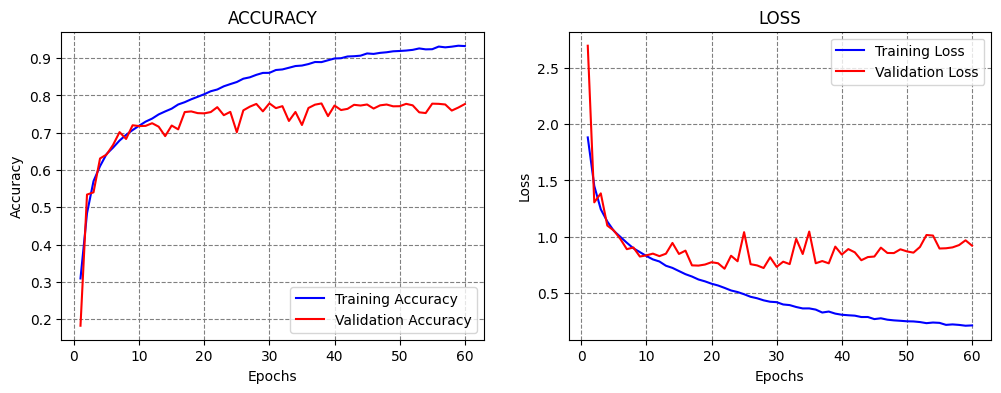

In [ ]:
# plot the accuracy and loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochsn = np.arange(1, len(train_loss)+1,1)
plt.figure(figsize=(12, 4))

plt.subplot(1,2,1)
plt.plot(epochsn, acc, 'b', label='Training Accuracy')
plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
plt.grid(color='gray', linestyle='--')
plt.legend()
plt.title('ACCURACY')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochsn,train_loss, 'b', label='Training Loss')
plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
plt.grid(color='gray', linestyle='--')
plt.legend()
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
# Evaluate on test dataset
evals_test = cifar_cnn_3.evaluate(test_data, test_label)
print("Classification Accuracy: ", evals_test[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7733 - loss: 0.8943
Classification Accuracy:  0.774399995803833


With the Batch Normalization layers in the model, the test accuracy increased to 77%.

## 15.7 Data Augmentation <a name='15.7-data-augmentation'></a>

One of the main reasons for overfitting is the lack of sufficient training samples, or lack of diversity in the training samples, for training a model.

To deal with overfitting we can use **data augmentation**, which refers to expanding the existing dataset by applying different image transformation operations. Examples are flipping the image vertically or horizontally, cropping the image, changing the contrast and color of the image, adding noise to the image, rotating the image at a given degree, and similar.

![Image Augmentation](https://cdn.hashnode.com/res/hashnode/image/upload/v1623166213173/JTRR1Btgm.png)

By doing data augmentation, we are synthesizing new images from existing data, as well as introducing some diversity in the images.

Keras provides the function `ImageDataGenerator` for data augmentation. Among the available operations for data augmentation are:

- **rotation_range** is a value in degrees (0–180) to randomly rotate images.
- **width_shift** and **height_shift** are ranges of fraction of total width or height within which to translate pictures, either vertically or horizontally.
- **shear_range** is for applying shearing randomly.
- **zoom_range** is for zooming in pictures randomly.
- **horizontal_flip** and **vertical_flip** are for flipping images.

In the example below we applied width shift, height shift, and horizontal flip.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# create data generator
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

ImageDataGenerator returns both the augmented images and their labels for each batch of images.

Let's plot a few images to see what they look like. They don't look much different, but that is because the applied shift and flip are not very large, and we didn't use other operations.

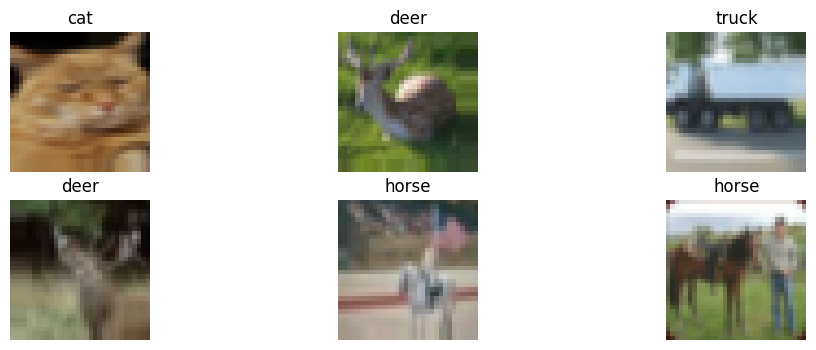

In [ ]:
# Get images in batch of 20
aug_iterator = datagen.flow(train_data, train_label, batch_size=1)

plt.figure(figsize=(12,4))
for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(aug_iterator[i][0][0])
        plt.title(str(label_names[aug_iterator[i][1][0][0]]))
        plt.axis("off")

When we use data augmentation, the arguments in the `fit` function are slightly different. First, we need to provide the name of our defined generator with `flow` to yield a batch of augmented images. In this case, we will need to use `datagen.flow`, since we assigned the image generator to the name `datagen`.

Also, the generator in Keras does not accept a `validation_split` argument, and therefore we need to manually create a validation dataset, and then use it. This has been done in the next cells.

In [ ]:
# Define the model with inputs and outputs
cifar_cnn_4 = Model(inputs, outputs)

# compile model
cifar_cnn_4.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
# fit model
history = cifar_cnn_4.fit(datagen.flow(train_data, train_label, batch_size=128),
                epochs=120, validation_split=0.2, verbose=0)

# note that the generator does not work with validation split

ValueError: Argument `validation_split` is only supported for tensors or NumPy arrays.Found incompatible type in the input: [<class 'keras.src.legacy.preprocessing.image.NumpyArrayIterator'>]

In [ ]:
from sklearn.model_selection import train_test_split

train_data_1, validation_data_1, train_label_1, validation_label_1 = train_test_split(train_data, train_label, test_size=0.2, random_state=20, stratify=train_label)

In [ ]:
print('Training images', train_data_1.shape)
print('Training labels', train_label_1.shape)
print('Validation_images', validation_data_1.shape)
print('Validation labels', validation_label_1.shape)

Training images (40000, 32, 32, 3)
Training labels (40000, 1)
Validation_images (10000, 32, 32, 3)
Validation labels (10000, 1)


In [ ]:
t = now()
# fit model
history= cifar_cnn_4.fit(datagen.flow(train_data_1, train_label_1, batch_size=128),
                epochs=100, validation_data=(validation_data_1, validation_label_1), verbose=0)

print('Training time: %s' % (now() - t))

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Training time: 0:40:03.832752


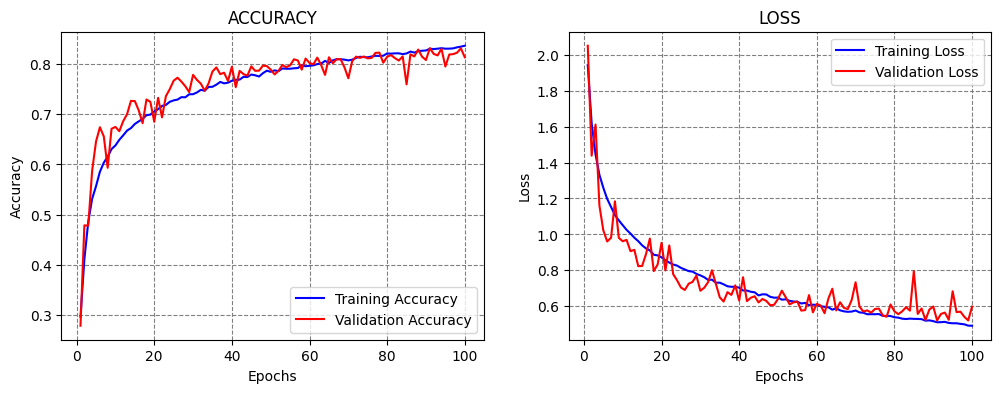

In [ ]:
# plot the accuracy and loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochsn = np.arange(1, len(train_loss)+1,1)
plt.figure(figsize=(12, 4))

plt.subplot(1,2,1)
plt.plot(epochsn, acc, 'b', label='Training Accuracy')
plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
plt.grid(color='gray', linestyle='--')
plt.legend()
plt.title('ACCURACY')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochsn,train_loss, 'b', label='Training Loss')
plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
plt.grid(color='gray', linestyle='--')
plt.legend()
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
# Evaluate on test dataset
evals_test = cifar_cnn_4.evaluate(test_data, test_label)
print("Classification Accuracy: ", evals_test[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8148 - loss: 0.6107
Classification Accuracy:  0.8140000104904175


The data augmentation was helpful to further improve the performance of the model to about 81% accuracy. We trained the model for 100 epochs, which took about 40 minutes. From the learning curves we can conclude that the accuracy was still increasing at epoch 100, therefore we could continue training the model, or we could have selected a higher number of epochs initially.

## 15.8 Transfer Learning <a name='15.8-transfer-learning'></a>

**Transfer learning** uses pretrained models that are trained on very large datasets to improve the performance on smaller datasets.

There are many pretrained models available in the `tensorflow.keras.applications` module.

Typical steps in transfer learning include:

- Initialize the pretrained model (base model) and weights, and remove the top layers (fully-connected layers) of the pretrained model.
- Create a new model by adding new trainable fully-connected layers on top of the primary model.
- Train the new model, and evaluate the performance.

In this case we will use the VGG16 model, which is popular for image classification. The model is imported with the weights pretrained on ImageNet, which is a very large dataset with 1.2 million images in 1,000 classes. Since our task has only 10 classes, we will remove the dense layers which are very specific to ImageNet's 1,000 classes, and add our own custom layers with 10 classes.

Transfer learning is also often referred to as **model fine-tuning**, because we start with a pretrained model and we fine-tune its parameters to our custom dataset.


In [ ]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras.layers import GlobalAveragePooling2D

base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(32,32,3))

# Add a global spatial average pooling  (is similar to the flatten flayer)
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(10, activation='softmax')(x)

# The model we will train
cifar_cnn_5 = Model(inputs=base_model.input, outputs=predictions)

### Early Stopping

TensorFlow-Keras has implemented several callbacks that allow to monitor the training process and have more control over it. We will study the various callbacks in the next lecture, and in this lecture we we explain how the callback Early Stopping works.

**EarlyStopping** monitors a metric (e.g., validation loss) and if the metric doesn't improve for a certain number of epochs (a.k.a. patience), terminates the training. By improve, we mean the decrease if the metric is loss, or increase if the metric is accuracy.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

cifar_cnn_5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

# fit model
t = now()
history = cifar_cnn_5.fit(train_data, train_label, validation_split=0.2, batch_size=128,
                    epochs=100, verbose=0, callbacks=[EarlyStopping(monitor='val_loss', patience = 10)])

print('Training time: %s' % (now() - t))

Training time: 0:08:07.423428


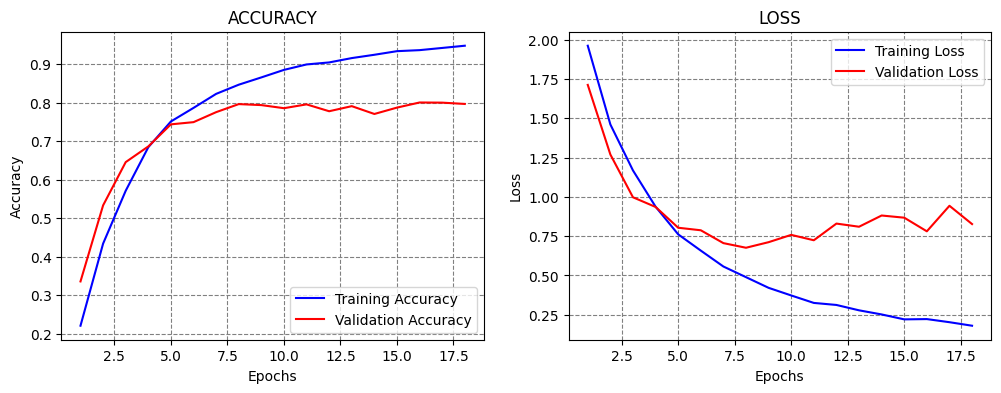

In [ ]:
# plot the accuracy and loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochsn = np.arange(1, len(train_loss)+1,1)
plt.figure(figsize=(12, 4))

plt.subplot(1,2,1)
plt.plot(epochsn, acc, 'b', label='Training Accuracy')
plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
plt.grid(color='gray', linestyle='--')
plt.legend()
plt.title('ACCURACY')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochsn,train_loss, 'b', label='Training Loss')
plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
plt.grid(color='gray', linestyle='--')
plt.legend()
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
# Evaluate on test dataset
evals_test = cifar_cnn_5.evaluate(test_data, test_label)
print("Classification Accuracy: ", evals_test[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7940 - loss: 0.8292
Classification Accuracy:  0.7943999767303467


Although the accuracy is reduced, note that the model was trained in about 15 epochs, in comparison to 100 epochs or more epochs when trained from scratch.

The following figure illustrates the early stopping callback. When the validation loss starts increasing, it terminates the training. In our case, the validation loss reached minimum at epoch 6, and since we specified a 10 epochs patience, the model stopped at epoch 16.

<img src="images/early_stopping.png" width="500">

*Figure: Early stopping.*

Let's try to use a pretrained model and combine it with data augmentation and early stopping.

In [ ]:
# The model we will train
cifar_cnn_6 = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# compile model
cifar_cnn_6.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
t = now()
# fit model
history= cifar_cnn_6.fit(datagen.flow(train_data_1, train_label_1, batch_size=128),
                epochs=100, validation_data=(validation_data_1, validation_label_1), verbose=0,
                callbacks=[EarlyStopping(monitor='val_loss', patience = 10)])

print('Training time: %s' % (now() - t))

Training time: 0:14:39.791182


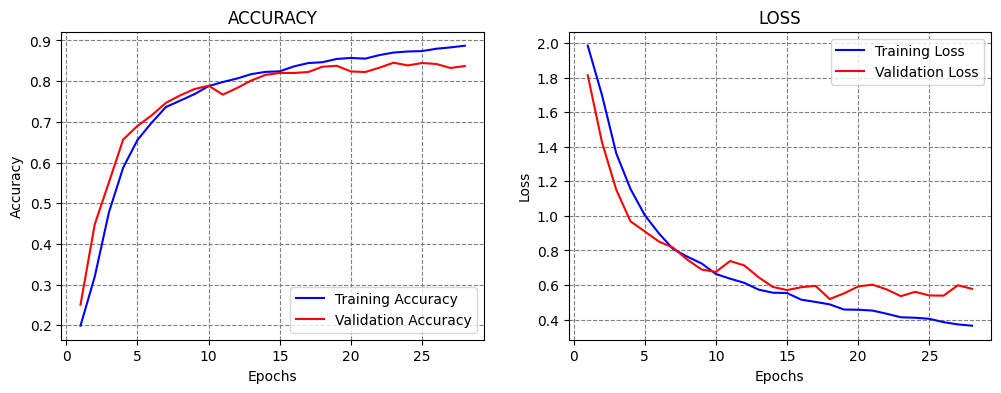

In [ ]:
# plot the accuracy and loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochsn = np.arange(1, len(train_loss)+1,1)
plt.figure(figsize=(12, 4))

plt.subplot(1,2,1)
plt.plot(epochsn, acc, 'b', label='Training Accuracy')
plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
plt.grid(color='gray', linestyle='--')
plt.legend()
plt.title('ACCURACY')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochsn,train_loss, 'b', label='Training Loss')
plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
plt.grid(color='gray', linestyle='--')
plt.legend()
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
# Evaluate on test dataset
evals_test = cifar_cnn_6.evaluate(test_data, test_label)
print("Classification Accuracy: ", evals_test[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8419 - loss: 0.5698
Classification Accuracy:  0.8348000049591064


Combining transfer learning with data augmentation increased the accuracy to above 83%.

## References <a name='references'></a>

1. Complete Machine Learning Package, Jean de Dieu Nyandwi, available at: [https://github.com/Nyandwi/machine_learning_complete](https://github.com/Nyandwi/machine_learning_complete).
2. How to Develop a CNN from Scratch for CIFAR-10 Photo Classification, Jason Brownlee, available at: [https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/](https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/).
3. Python Machine Learning (2nd Ed.) Code Repository, Sebastian Raschka, available at: [https://github.com/rasbt/python-machine-learning-book-2nd-edition](https://github.com/rasbt/python-machine-learning-book-2nd-edition).


[BACK TO TOP](#top)